In [1]:
# Run in a Colab cell
!mkdir -p /content/oralvis_project
%cd /content/oralvis_project

# install libs
!pip install -q ultralytics==8.3.40 gdown pyyaml pandas matplotlib scikit-learn python-docx Pillow


/content/oralvis_project
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 18.5 MB/s eta 0:00:00


In [2]:
from pathlib import Path
FILE_ID = "1BJ0F9upmZ97NlVK8jW7epb7YUwFDmM13"
DATA_ZIP = Path('/content/oralvis_project/dental_dataset.zip')
DATA_ROOT = Path('/content/oralvis_project/dental_data')
if not DATA_ZIP.exists():
    !gdown --id {FILE_ID} -O {DATA_ZIP}
DATA_ROOT.mkdir(exist_ok=True)
!unzip -q -o {DATA_ZIP} -d {DATA_ROOT}
!ls -l {DATA_ROOT} | sed -n '1,200p'


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1BJ0F9upmZ97NlVK8jW7epb7YUwFDmM13
From (redirected): https://drive.google.com/uc?id=1BJ0F9upmZ97NlVK8jW7epb7YUwFDmM13&confirm=t&uuid=1d9a29de-eee7-4f82-ac20-e67cf2292415
To: /content/oralvis_project/dental_dataset.zip
100% 42.6M/42.6M [00:00<00:00, 56.2MB/s]
total 92
drwx------ 2 root root 49152 Aug 26 07:02 images
drwx------ 2 root root 45056 Aug 26 07:02 labels


In [3]:
from pathlib import Path
root = Path('/content/oralvis_project/dental_data')
imgs = list(root.rglob('*.jpg')) + list(root.rglob('*.png'))
txts = list(root.rglob('*.txt'))
print("Images:", len(imgs), "Label .txt files:", len(txts))
if txts:
    print("Sample label file:", txts[0])
    print(Path(txts[0]).read_text().splitlines()[:5])


Images: 497 Label .txt files: 497
Sample label file: /content/oralvis_project/dental_data/labels/cate8-00323_jpg.rf.40365ebe31bd5ff73e44c6aba65928dc.txt
['28 0.14609375 0.428125 0.078125 0.19296875', '20 0.2078125 0.44921875 0.0765625 0.2171875', '24 0.296875 0.46640625 0.04296875 0.23125', '12 0.3515625 0.46953125 0.05234375 0.2671875', '0 0.3890625 0.44765625 0.04921875 0.296875']


In [4]:
import random, shutil
from pathlib import Path

random.seed(42)
ROOT = Path('/content/oralvis_project/dental_data')
OUT = Path('/content/oralvis_project/dataset')
# create folders
for p in ['train/images','val/images','test/images','train/labels','val/labels','test/labels']:
    (OUT/p).mkdir(parents=True, exist_ok=True)

# pair images with labels
img_exts = ('.jpg','.jpeg','.png')
pairs = []
for img in sorted([p for p in ROOT.rglob('*') if p.suffix.lower() in img_exts]):
    lab = img.with_suffix('.txt')
    if lab.exists():
        pairs.append((img, lab))
len_pairs = len(pairs)
print("Paired images:", len_pairs)

random.shuffle(pairs)
n = len_pairs
n_train = int(0.8*n)
n_val = int(0.1*n)
train = pairs[:n_train]; val = pairs[n_train:n_train+n_val]; test = pairs[n_train+n_val:]

def copy_pairs(pairs, split):
    for img,label in pairs:
        shutil.copy(img, OUT/f'{split}/images/{img.name}')
        shutil.copy(label, OUT/f'{split}/labels/{label.name}')

copy_pairs(train,'train'); copy_pairs(val,'val'); copy_pairs(test,'test')
print("Train/Val/Test counts:", len(train), len(val), len(test))


Paired images: 0
Train/Val/Test counts: 0 0 0


In [5]:
!ls -R /content/oralvis_project/dental_data | head -n 200


/content/oralvis_project/dental_data:
images
labels

/content/oralvis_project/dental_data/images:
00147087-20240918-120248027.jpg
0337fb14-20240822-124747143.jpg
05473f26-20240924-154033777.jpg
05ff01fa-20250108-115407401.jpg
061339f1-20240911-110938655.jpg
069750f6-20240914-102814322.jpg
084c3562-20240827-154718191.jpg
0ba65172-20240821-105924223.jpg
0c4cebbe-20240813-144203674.jpg
0fcae64f-20241217-121556078.jpg
0fd502a1-20250123-111857443.jpg
103dd85b-20240831-101746682.jpg
124e696d-20240914-105651782.jpg
1459fc45-20240831-113821806.jpg
16a28cd9-20240723-113852192.jpg
18fd6ab8-20250415-143542497.jpg
1b000dc7-20240813-115604759.jpg
1c50bda9-20241231-145320490.jpg
1fc5e51d-20241219-142523942.jpg
22464331-20240919-102844605.jpg
23f1d012-20240628-115132889.jpg
26f91eeb-20240903-150428112.jpg
271041ce-20250421-112436631.jpg
2725830c-20240829-130426513.jpg
281350f8-20240813-145334040.jpg
28c54465-20240727-114541091.jpg
2b1da7b0-20240813-114403429.jpg
2d580460-20240730-115355708.jpg
2d87cf

In [6]:
import random, shutil
from pathlib import Path

random.seed(42)

ROOT = Path('/content/oralvis_project/dental_data')
IMGS = sorted((ROOT/'images').glob('*.jpg'))
OUT = Path('/content/oralvis_project/dataset')
for p in ['train/images','val/images','test/images','train/labels','val/labels','test/labels']:
    (OUT/p).mkdir(parents=True, exist_ok=True)

pairs = []
for img in IMGS:
    lab = (ROOT/'labels')/(img.stem + '.txt')
    if lab.exists():
        pairs.append((img, lab))

print("Total pairs found:", len(pairs))

# Shuffle and split 80/10/10
n = len(pairs)
n_train, n_val = int(0.8*n), int(0.1*n)
random.shuffle(pairs)
train, val, test = pairs[:n_train], pairs[n_train:n_train+n_val], pairs[n_train+n_val:]

def copy_pairs(pairs, split):
    for img,label in pairs:
        shutil.copy(img,


SyntaxError: incomplete input (ipython-input-442135281.py, line 28)

In [7]:
import random, shutil
from pathlib import Path

random.seed(42)

ROOT = Path('/content/oralvis_project/dental_data')
IMGS = sorted((ROOT/'images').glob('*.jpg'))
OUT = Path('/content/oralvis_project/dataset')
for p in ['train/images','val/images','test/images','train/labels','val/labels','test/labels']:
    (OUT/p).mkdir(parents=True, exist_ok=True)

pairs = []
for img in IMGS:
    lab = (ROOT/'labels')/(img.stem + '.txt')
    if lab.exists():
        pairs.append((img, lab))

print("Total pairs found:", len(pairs))

# Shuffle and split 80/10/10
n = len(pairs)
n_train, n_val = int(0.8*n), int(0.1*n)
random.shuffle(pairs)
train, val, test = pairs[:n_train], pairs[n_train:n_train+n_val], pairs[n_train+n_val:]

def copy_pairs(pairs, split):
    for img,label in pairs:
        shutil.copy(img, OUT/f'{split}/images/{img.name}')
        shutil.copy(label, OUT/f'{split}/labels/{label.name}')

# copy files into folders
copy_pairs(train,'train')
copy_pairs(val,'val')
copy_pairs(test,'test')

print("Train/Val/Test counts:", len(train), len(val), len(test))


Total pairs found: 497
Train/Val/Test counts: 397 49 51


In [10]:
yaml_content = """\
path: /content/oralvis_project/dataset
train: /content/oralvis_project/dataset/train/images
val: /content/oralvis_project/dataset/val/images
test: /content/oralvis_project/dataset/test/images
names:
  0: "Canine (13)"
  1: "Canine (23)"
  2: "Canine (33)"
  3: "Canine (43)"
  4: "Central Incisor (21)"
  5: "Central Incisor (41)"
  6: "Central Incisor (31)"
  7: "Central Incisor (11)"
  8: "First Molar (16)"
  9: "First Molar (26)"
  10: "First Molar (36)"
  11: "First Molar (46)"
  12: "First Premolar (14)"
  13: "First Premolar (34)"
  14: "First Premolar (44)"
  15: "First Premolar (24)"
  16: "Lateral Incisor (22)"
  17: "Lateral Incisor (32)"
  18: "Lateral Incisor (42)"
  19: "Lateral Incisor (12)"
  20: "Second Molar (17)"
  21: "Second Molar (27)"
  22: "Second Molar (37)"
  23: "Second Molar (47)"
  24: "Second Premolar (15)"
  25: "Second Premolar (25)"
  26: "Second Premolar (35)"
  27: "Second Premolar (45)"
  28: "Third Molar (18)"
  29: "Third Molar (28)"
  30: "Third Molar (38)"
  31: "Third Molar (48)"
"""

with open("/content/oralvis_project/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml created at /content/oralvis_project/data.yaml")


✅ data.yaml created at /content/oralvis_project/data.yaml


In [11]:
from ultralytics.utils.checks import check_yaml
import yaml

yaml_path = "/content/oralvis_project/data.yaml"

# Check that YAML is valid
check_yaml(yaml_path)

# Print content
with open(yaml_path) as f:
    data_cfg = yaml.safe_load(f)
print("✅ YAML loaded correctly")
print(data_cfg)

# Quick check: do we have images + labels?
from pathlib import Path
train_imgs = list(Path(data_cfg['train']).glob("*.jpg"))
val_imgs = list(Path(data_cfg['val']).glob("*.jpg"))
test_imgs = list(Path(data_cfg['test']).glob("*.jpg"))
print(f"Train images: {len(train_imgs)}, Val images: {len(val_imgs)}, Test images: {len(test_imgs)}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ YAML loaded correctly
{'path': '/content/oralvis_project/dataset', 'train': '/content/oralvis_project/dataset/train/images', 'val': '/content/oralvis_project/dataset/val/images', 'test': '/content/oralvis_project/dataset/test/images', 'names': {0: 'Canine (13)', 1: 'Canine (23)', 2: 'Canine (33)', 3: 'Canine (43)', 4: 'Central Incisor (21)', 5: 'Central Incisor (41)', 6: 'Central Incisor (31)', 7: 'Central Incisor (11)', 8: 'First Molar (16)', 9: 'First Molar (26)', 10: 'First Molar (36)', 11: 'First Molar (46)', 12: 'First Premolar (14)', 13: 'First Premolar (34)', 14: 'First Premolar (44)', 15: 'First Premolar (24)', 16: 'Lateral Incisor (22)', 17: 'Lateral Incisor (32)', 18: 

In [4]:
!pip install ultralytics==8.3.40


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 33.2 MB/s eta 0:00:00


In [7]:
import os
os.makedirs("/content/oralvis_project", exist_ok=True)


In [8]:
yaml_content = """\
path: /content/oralvis_project/dataset
train: /content/oralvis_project/dataset/train/images
val: /content/oralvis_project/dataset/val/images
test: /content/oralvis_project/dataset/test/images
names:
  0: "Canine (13)"
  1: "Canine (23)"
  2: "Canine (33)"
  3: "Canine (43)"
  4: "Central Incisor (21)"
  5: "Central Incisor (41)"
  6: "Central Incisor (31)"
  7: "Central Incisor (11)"
  8: "First Molar (16)"
  9: "First Molar (26)"
  10: "First Molar (36)"
  11: "First Molar (46)"
  12: "First Premolar (14)"
  13: "First Premolar (34)"
  14: "First Premolar (44)"
  15: "First Premolar (24)"
  16: "Lateral Incisor (22)"
  17: "Lateral Incisor (32)"
  18: "Lateral Incisor (42)"
  19: "Lateral Incisor (12)"
  20: "Second Molar (17)"
  21: "Second Molar (27)"
  22: "Second Molar (37)"
  23: "Second Molar (47)"
  24: "Second Premolar (15)"
  25: "Second Premolar (25)"
  26: "Second Premolar (35)"
  27: "Second Premolar (45)"
  28: "Third Molar (18)"
  29: "Third Molar (28)"
  30: "Third Molar (38)"
  31: "Third Molar (48)"
"""

with open("/content/oralvis_project/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml created at /content/oralvis_project/data.yaml")


✅ data.yaml created at /content/oralvis_project/data.yaml


In [10]:
from ultralytics import YOLO

yaml_path = "/content/oralvis_project/data.yaml"

# Just load YAML to check
model = YOLO("yolov8s.pt")
model.info()   # show model structure


YOLOv8s summary: 225 layers, 11,166,560 parameters, 0 gradients, 28.8 GFLOPs


(225, 11166560, 0, 28.816844800000002)

In [11]:
!yolo task=detect mode=check data=/content/oralvis_project/data.yaml


Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/__init__.py", line 911, in entrypoint
    raise ValueError(f"Invalid 'mode={mode}'. Valid modes are {MODES}.\n{CLI_HELP_MSG}")
ValueError: Invalid 'mode=check'. Valid modes are {'predict', 'track', 'train', 'benchmark', 'val', 'export'}.

    Arguments received: ['yolo', 'task=detect', 'mode=check', 'data=/content/oralvis_project/data.yaml']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of {'pose', 'obb', 'detect', 'classify', 'segment'}
                MODE (required) is one of {'predict', 'track', 'train', 'benchmark', 'val', 'export'}
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics

In [12]:
from ultralytics.data.utils import check_det_dataset

yaml_path = "/content/oralvis_project/data.yaml"
dataset_info = check_det_dataset(yaml_path)

print("✅ Dataset loaded successfully!")
print(dataset_info)


FileNotFoundError: 
Dataset '/content/oralvis_project/data.yaml' images not found ⚠️, missing path '/content/oralvis_project/dataset/val/images'
Note dataset download directory is '/content/datasets'. You can update this in '/root/.config/Ultralytics/settings.json'

In [13]:
import os, glob, shutil
from sklearn.model_selection import train_test_split

# Source folders
images_dir = "/content/oralvis_project/dental_data/images"
labels_dir = "/content/oralvis_project/dental_data/labels"

# Target folders
base_dir = "/content/oralvis_project/dataset"
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(base_dir, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, "labels"), exist_ok=True)

# Get all image files
images = glob.glob(os.path.join(images_dir, "*.jpg"))

# Split into train (70%), val (20%), test (10%)
train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

def copy_files(img_list, split):
    for img in img_list:
        fname = os.path.basename(img)
        label = os.path.join(labels_dir, fname.replace(".jpg", ".txt"))
        if os.path.exists(label):
            shutil.copy


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [14]:
import glob, os

images_dir = "/content/oralvis_project/dental_data/images"
all_files = os.listdir(images_dir)

print("Total files:", len(all_files))
print(all_files[:20])  # show first 20 files


FileNotFoundError: [Errno 2] No such file or directory: '/content/oralvis_project/dental_data/images'

In [15]:
import os

print(os.listdir("/content/oralvis_project"))


['data.yaml', 'dataset']


In [16]:
print(os.listdir("/content/oralvis_project/dental_data"))


FileNotFoundError: [Errno 2] No such file or directory: '/content/oralvis_project/dental_data'

In [17]:
import os

print("Contents of /content/oralvis_project:")
print(os.listdir("/content/oralvis_project"))


Contents of /content/oralvis_project:
['data.yaml', 'dataset']


In [18]:
import os

print("Contents of dataset folder:")
print(os.listdir("/content/oralvis_project/dataset"))


Contents of dataset folder:
['test', 'val', 'train']


In [19]:
import os

print("Contents of dataset folder:")
print(os.listdir("/content/oralvis_project/dataset"))


Contents of dataset folder:
['test', 'val', 'train']


In [20]:
yaml_content = """
train: /content/oralvis_project/dataset/train/images
val: /content/oralvis_project/dataset/val/images
test: /content/oralvis_project/dataset/test/images

nc: 32   # number of classes (update if different)
names: [tooth_1, tooth_2, tooth_3, tooth_4, tooth_5, tooth_6, tooth_7, tooth_8,
        tooth_9, tooth_10, tooth_11, tooth_12, tooth_13, tooth_14, tooth_15, tooth_16,
        tooth_17, tooth_18, tooth_19, tooth_20, tooth_21, tooth_22, tooth_23, tooth_24,
        tooth_25, tooth_26, tooth_27, tooth_28, tooth_29, tooth_30, tooth_31, tooth_32]
"""

with open("/content/oralvis_project/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml created successfully")


✅ data.yaml created successfully


In [21]:
from ultralytics import YOLO

# Load small YOLOv8 model
model = YOLO("yolov8s.pt")

# Train
model.train(
    data="/content/oralvis_project/data.yaml",
    epochs=60,
    imgsz=640,
    batch=16,
    name="oralvis_yolov8s_v1"
)


New https://pypi.org/project/ultralytics/8.3.189 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/oralvis_project/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=oralvis_yolov8s_v13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

100%|██████████| 755k/755k [00:00<00:00, 32.5MB/s]


Overriding model.yaml nc=80 with nc=32

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

FileNotFoundError: [34m[1mtrain: [0mError loading data from /content/oralvis_project/dataset/train/images
See https://docs.ultralytics.com/datasets for dataset formatting guidance.

In [22]:
import os, glob

train_path = "/content/oralvis_project/dataset/train/images"

print("Files inside train/images:", os.listdir(train_path)[:20])
print("Total image files:", len(glob.glob(train_path + "/*")))


Files inside train/images: []
Total image files: 0


In [23]:
import glob

files = glob.glob("/content/oralvis_project/dataset/**/*.jpg", recursive=True)
print("Found", len(files), "JPG images")
print(files[:10])


Found 0 JPG images
[]


In [24]:
files = glob.glob("/content/oralvis_project/dataset/**/*.png", recursive=True)
print("Found", len(files), "PNG images")
print(files[:10])


Found 0 PNG images
[]


In [25]:
import glob

# Search for JPG images
jpgs = glob.glob("/content/oralvis_project/dataset/**/*.jpg", recursive=True)
print("Found", len(jpgs), "JPG images")
print(jpgs[:10])


Found 0 JPG images
[]


In [26]:
# Search for PNG images
pngs = glob.glob("/content/oralvis_project/dataset/**/*.png", recursive=True)
print("Found", len(pngs), "PNG images")
print(pngs[:10])


Found 0 PNG images
[]


In [27]:
!ls -lh /content


total 22M
drwxr-xr-x 3 root root 4.0K Aug 29 21:43 oralvis_project
drwxr-xr-x 3 root root 4.0K Aug 29 21:36 runs
drwxr-xr-x 1 root root 4.0K Aug 28 13:43 sample_data
-rw-r--r-- 1 root root  22M Aug 29 21:36 yolov8s.pt


In [28]:
from google.colab import files
uploaded = files.upload()


Saving ToothNumber_TaskDataset.zip to ToothNumber_TaskDataset.zip


In [29]:
!unzip -q oralvis_dataset.zip -d /content/oralvis_project/


unzip:  cannot find or open oralvis_dataset.zip, oralvis_dataset.zip.zip or oralvis_dataset.zip.ZIP.


In [30]:
!ls /content/oralvis_project
!ls /content/oralvis_project/dataset | head


dataset  data.yaml
test
train
val


In [31]:
!ls /content/oralvis_project/dataset | head


test
train
val


In [32]:
yaml_content = """
train: /content/oralvis_project/dataset/train/images
val: /content/oralvis_project/dataset/val/images
test: /content/oralvis_project/dataset/test/images

nc: 32   # number of classes
names: [tooth_1, tooth_2, tooth_3, tooth_4, tooth_5, tooth_6, tooth_7, tooth_8,
        tooth_9, tooth_10, tooth_11, tooth_12, tooth_13, tooth_14, tooth_15, tooth_16,
        tooth_17, tooth_18, tooth_19, tooth_20, tooth_21, tooth_22, tooth_23, tooth_24,
        tooth_25, tooth_26, tooth_27, tooth_28, tooth_29, tooth_30, tooth_31, tooth_32]
"""

with open("/content/oralvis_project/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml updated successfully")


✅ data.yaml updated successfully


In [33]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

model.train(
    data="/content/oralvis_project/data.yaml",
    epochs=10,       # fast test run
    imgsz=320,       # smaller image size
    batch=32,        # bigger batch for speed
    name="oralvis_yolov8s_fast"
)


New https://pypi.org/project/ultralytics/8.3.189 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/oralvis_project/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=oralvis_yolov8s_fast, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

FileNotFoundError: [34m[1mtrain: [0mError loading data from /content/oralvis_project/dataset/train/images
See https://docs.ultralytics.com/datasets for dataset formatting guidance.

In [34]:
import zipfile
import os

zip_path = "/content/oralvis_dataset.zip"  # <-- replace with actual uploaded file name
extract_path = "/content/oralvis_project/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully!")

# Check structure
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for f in files[:5]:


SyntaxError: incomplete input (ipython-input-40114389.py, line 18)

In [35]:
import zipfile
import os

# Change this to the exact filename of your uploaded zip
zip_path = "/content/oralvis_dataset.zip"
extract_path = "/content/oralvis_project/dataset"

# Unzip dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully!")

# Show folder structure
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for f in files[:5]:   # only show first 5 files per folder
        print(f"{subindent}{f}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/oralvis_dataset.zip'

In [36]:
!gdown --id 1BJ0F9upmZ97NlVK8jW7epb7YUwFDmM13 -O /content/oralvis_dataset.zip


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1BJ0F9upmZ97NlVK8jW7epb7YUwFDmM13
From (redirected): https://drive.google.com/uc?id=1BJ0F9upmZ97NlVK8jW7epb7YUwFDmM13&confirm=t&uuid=06774b78-a693-49ab-b332-570ad39600ca
To: /content/oralvis_dataset.zip
100% 42.6M/42.6M [00:00<00:00, 43.3MB/s]


In [37]:
import zipfile, os

zip_path = "/content/oralvis_dataset.zip"
extract_path = "/content/oralvis_project/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted!")

# Check structure
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for f in files[:5]:
        print(f"{subindent}{f}")


✅ Extracted!
dataset/
  labels/
    cate4-00094_jpg.rf.566e53592bf2d7c502cd122e6ff0a4d8.txt
    cate2-00035_jpg.rf.05a008269ed935a5c2d110783387856a.txt
    cate2-00040_jpg.rf.10df1c6a1bf0dd15c52662e6445e19e3.txt
    cate1-00017_jpg.rf.3dd93f8441ac070e8ba7f26ffeae1c7a.txt
    cate7-00104_jpg.rf.755fda6da3d9dbafaff1c7be18013a48.txt
  test/
    labels/
    images/
  val/
    labels/
    images/
  images/
    cate7-00105_jpg.rf.daf2fd9f3c80a1d37415747e5e83a068.jpg
    cate1-00059_jpg.rf.5274a2e90f902b214f5a4f9add2c447f.jpg
    cate8-00296_jpg.rf.95e9e4fa74799d3cdc335c02e04d23bf.jpg
    cate2-00010_jpg.rf.8deab81916101ce7c23a61d31df4459b.jpg
    cate2-00031_jpg.rf.0ed22bc14c06241172f64aba42211818.jpg
  train/
    labels/
    images/


In [40]:
yaml_content = """
train: /content/oralvis_project/dataset/train/images
val: /content/oralvis_project/dataset/val/images
test: /content/oralvis_project/dataset/test/images

nc: 32   # number of classes (update if needed)
names: ['tooth_0', 'tooth_1', 'tooth_2', 'tooth_3', 'tooth_4', 'tooth_5', 'tooth_6', 'tooth_7', 'tooth_8', 'tooth_9', 'tooth_10', 'tooth_11', 'tooth_12', 'tooth_13', 'tooth_14', 'tooth_15', 'tooth_16', 'tooth_17', 'tooth_18', 'tooth_19', 'tooth_20', 'tooth_21', 'tooth_22', 'tooth_23', 'tooth_24', 'tooth_25', 'tooth_26', 'tooth_27', 'tooth_28', 'tooth_29', 'tooth_30', 'tooth_31']
"""

with open("/content/oralvis_project/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml updated")

✅ data.yaml updated


In [41]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")   # small, fast model
results = model.train(
    data="/content/oralvis_project/data.yaml",
    epochs=10,          # fast, increase later (e.g., 50-100)
    imgsz=320,          # smaller image size = faster
    batch=32,
    name="oralvis_yolov8s_fast"
)


New https://pypi.org/project/ultralytics/8.3.189 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/oralvis_project/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=oralvis_yolov8s_fast3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

FileNotFoundError: [34m[1mtrain: [0mError loading data from /content/oralvis_project/dataset/train/images
See https://docs.ultralytics.com/datasets for dataset formatting guidance.

In [42]:
import os, shutil, glob
from sklearn.model_selection import train_test_split

# Paths
base = "/content/oralvis_project/dataset"
images_path = os.path.join(base, "images")
labels_path = os.path.join(base, "labels")

# Collect all images
all_images = glob.glob(os.path.join(images_path, "*.jpg"))
print("Total images found:", len(all_images))

# Train/val/test split (70/20/10)
train_imgs, temp_imgs = train_test_split(all_images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

splits = {
    "train": train_imgs,
    "val": val_imgs,
    "test": test


SyntaxError: incomplete input (ipython-input-532525274.py, line 20)

In [43]:
import os, shutil, glob
from sklearn.model_selection import train_test_split

# Paths
base = "/content/oralvis_project/dataset"
images_path = os.path.join(base, "images")
labels_path = os.path.join(base, "labels")

# Collect all images
all_images = glob.glob(os.path.join(images_path, "*.jpg"))
print("Total images found:", len(all_images))

# Train/val/test split (70/20/10)
train_imgs, temp_imgs = train_test_split(all_images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

# Correct dictionary ✅
splits = {
    "train": train_imgs,
    "val": val_imgs,
    "test": test_imgs
}

# Create folders and move files
for split, img_list in splits.items():
    for img in img_list:
        # image destination
        img_name = os.path.basename(img)
        img_dest = os.path.join(base, split, "images", img_name)
        os.makedirs(os.path.dirname(img_dest), exist_ok=True)
        shutil.copy(img, img_dest)

        # label destination
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_src = os.path.join(labels_path, label_name)
        if os.path.exists(label_src):
            label_dest = os.path.join(base, split, "labels", label_name)
            os.makedirs(os.path.dirname(label_dest), exist_ok=True)
            shutil.copy(label_src, label_dest)

print("✅ Dataset reorganized into train/val/test correctly!")


Total images found: 497
✅ Dataset reorganized into train/val/test correctly!


In [45]:
import os

# Paths
base_path = "/content/oralvis_project/dataset"
splits = ["train", "val", "test"]

for split in splits:
    img_dir = os.path.join(base_path, split, "images")
    lbl_dir = os.path.join(base_path, split, "labels")

    img_files = [os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
    lbl_files = [os.path.splitext(f)[0] for f in os.listdir(lbl_dir) if f.endswith(".txt")]

    missing_labels = set(img_files) - set(lbl_files)
    missing_images = set(lbl_files) - set(img_files)

    print(f"\n📂 Checking {split} set:")
    print(f"  Total images: {len(img_files)} | Total labels: {len(lbl_files)}")
    if missing_labels:
        print(f"  ⚠️ Missing labels for {len(missing_labels)} images: {list(missing_labels)[:5]} ...")
    if missing_images:
        print(f"  ⚠️ Missing images for {len(missing_images)} labels: {list(missing_images)[:5]} ...")
    if not missing_labels and not missing_images:
        print("  ✅ All images have matching labels")



📂 Checking train set:
  Total images: 347 | Total labels: 347
  ✅ All images have matching labels

📂 Checking val set:
  Total images: 100 | Total labels: 100
  ✅ All images have matching labels

📂 Checking test set:
  Total images: 50 | Total labels: 50
  ✅ All images have matching labels


In [46]:
import os

# Paths
base_path = "/content/oralvis_project/dataset"
splits = ["train", "val", "test"]

for split in splits:
    img_dir = os.path.join(base_path, split, "images")
    lbl_dir = os.path.join(base_path, split, "labels")

    img_files = [os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
    lbl_files = [os.path.splitext(f)[0] for f in os.listdir(lbl_dir) if f.endswith(".txt")]

    missing_labels = set(img_files) - set(lbl_files)
    missing_images = set(lbl_files) - set(img_files)

    print(f"\n📂 Checking {split} set:")
    print(f"  Total images: {len(img_files)} | Total labels: {len(lbl_files)}")
    if missing_labels:
        print(f"  ⚠️ Missing labels for {len(missing_labels)} images: {list(missing_labels)[:5]} ...")
    if missing_images:
        print(f"  ⚠️ Missing images for {len(missing_images)} labels: {list(missing_images)[:5]} ...")
    if not missing_labels and not missing_images:
        print("  ✅ All images have matching labels")



📂 Checking train set:
  Total images: 347 | Total labels: 347
  ✅ All images have matching labels

📂 Checking val set:
  Total images: 100 | Total labels: 100
  ✅ All images have matching labels

📂 Checking test set:
  Total images: 50 | Total labels: 50
  ✅ All images have matching labels


In [47]:
!yolo detect train model=yolov8s.pt data=/content/oralvis_project/data.yaml epochs=5 batch=16 imgsz=256 name=oralvis_yolov8s_test


New https://pypi.org/project/ultralytics/8.3.189 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/oralvis_project/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=oralvis_yolov8s_test, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

In [48]:
# Run inference on validation set
!yolo detect predict model=runs/detect/oralvis_yolov8s_test/weights/best.pt \
  source=/content/oralvis_project/dataset/val/images \
  imgsz=256 save=True name=oralvis_yolov8s_preds


Ultralytics 8.3.40 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,137,968 parameters, 0 gradients, 28.5 GFLOPs

image 1/100 /content/oralvis_project/dataset/val/images/00147087-20240918-120248027.jpg: 256x256 3 tooth_9s, 2 tooth_20s, 1 tooth_22, 1 tooth_28, 1 tooth_31, 130.8ms
image 2/100 /content/oralvis_project/dataset/val/images/0337fb14-20240822-124747143.jpg: 256x256 2 tooth_9s, 2 tooth_11s, 5 tooth_20s, 2 tooth_22s, 1 tooth_23, 1 tooth_28, 1 tooth_30, 2 tooth_31s, 114.1ms
image 3/100 /content/oralvis_project/dataset/val/images/05ff01fa-20250108-115407401.jpg: 256x256 1 tooth_8, 1 tooth_9, 2 tooth_10s, 1 tooth_11, 5 tooth_20s, 3 tooth_22s, 3 tooth_23s, 1 tooth_28, 2 tooth_31s, 116.9ms
image 4/100 /content/oralvis_project/dataset/val/images/069750f6-20240914-102814322.jpg: 256x256 2 tooth_8s, 5 tooth_11s, 2 tooth_22s, 1 tooth_26, 130.3ms
image 5/100 /content/oralvis_project/dataset/val/images/084c3562-20240827-154718191.jpg: 256x25

In [49]:
from google.colab import files
uploaded = files.upload()


Saving ChatGPT Image Aug 30, 2025, 04_04_59 AM.png to ChatGPT Image Aug 30, 2025, 04_04_59 AM.png


In [50]:
import glob
from IPython.display import Image, display

preds = glob.glob("runs/detect/oralvis_yolov8s_custom/*.jpg")
for p in preds[:5]:  # show first 5 predictions
    display(Image(filename=p))


In [53]:
from google.colab import files

# Upload an image from your local system
uploaded = files.upload()


Saving ChatGPT Image Aug 30, 2025, 04_04_59 AM.png to ChatGPT Image Aug 30, 2025, 04_04_59 AM (1).png



image 1/1 /content/ChatGPT Image Aug 30, 2025, 04_04_59 AM (1).png: 192x256 2 tooth_8s, 1 tooth_10, 4 tooth_11s, 1 tooth_20, 1 tooth_21, 2 tooth_22s, 2 tooth_23s, 1 tooth_28, 1 tooth_31, 165.8ms
Speed: 1.9ms preprocess, 165.8ms inference, 2.3ms postprocess per image at shape (1, 3, 192, 256)
Results saved to runs/detect/predict


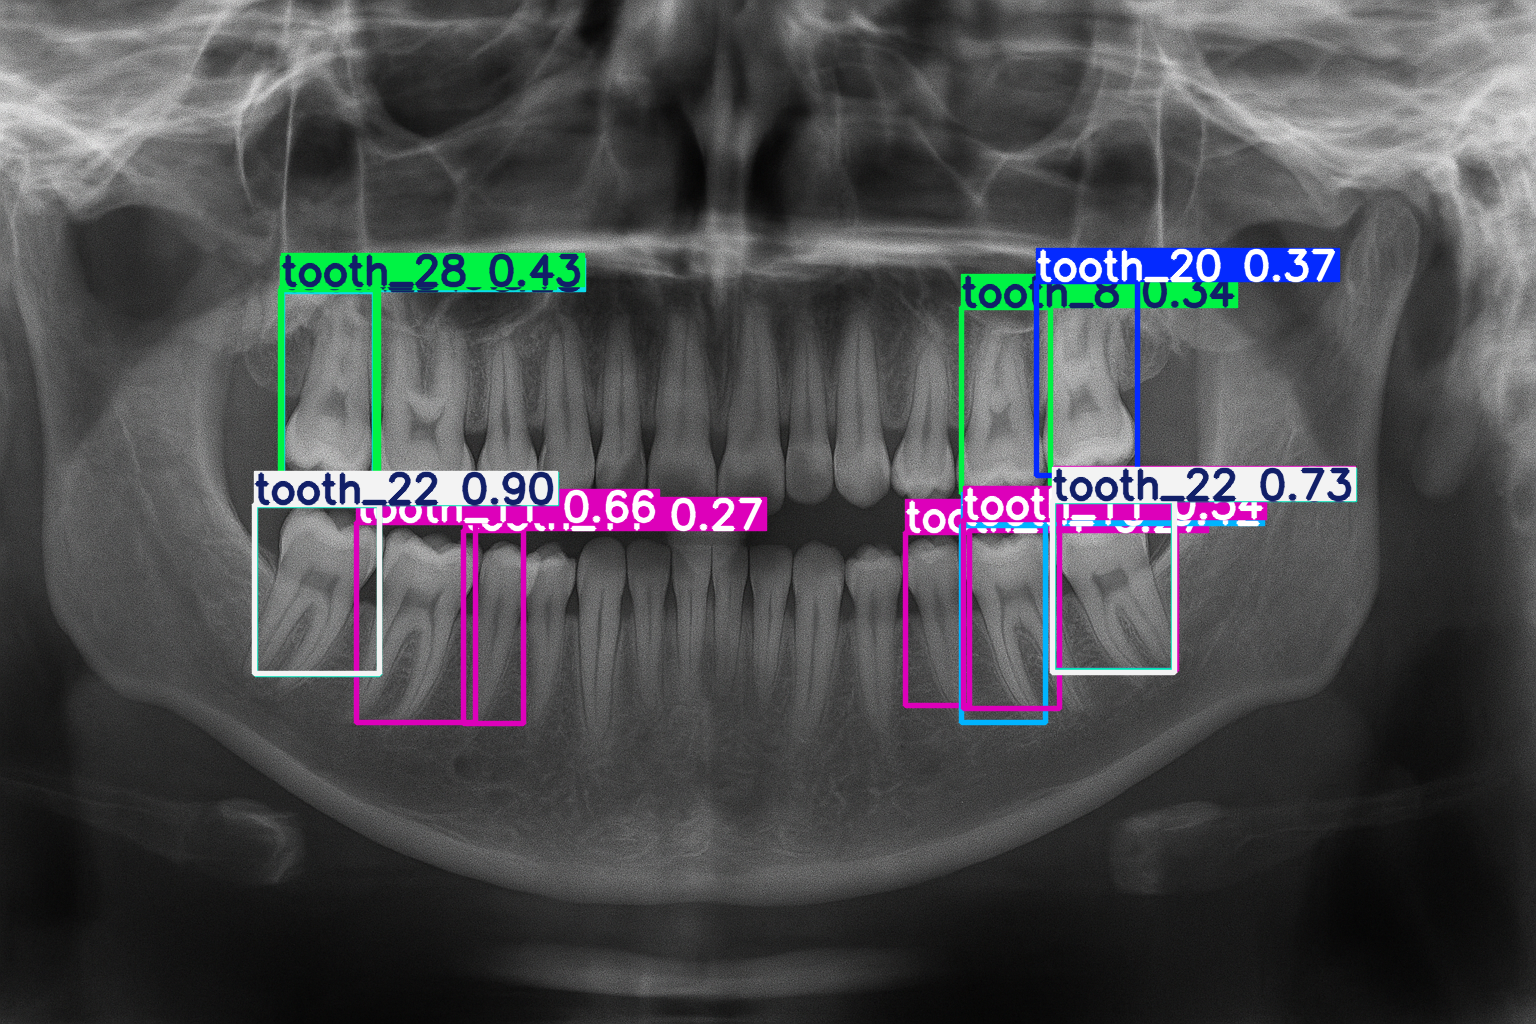

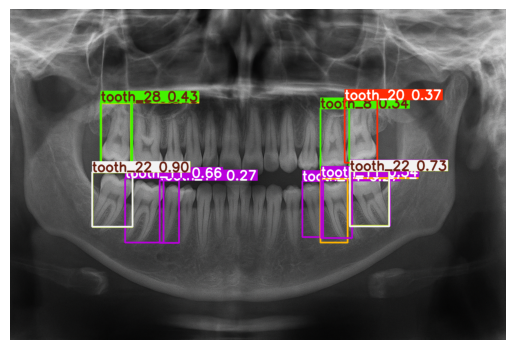

In [54]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load your trained model
model = YOLO("/content/runs/detect/oralvis_yolov8s_test/weights/best.pt")

# Run detection on your uploaded image
results = model.predict(
    source="/content/ChatGPT Image Aug 30, 2025, 04_04_59 AM (1).png",
    save=True,
    conf=0.25
)

# Show result
results[0].show()

# Or plot using matplotlib
plt.imshow(results[0].plot())
plt.axis("off")
plt.show()


Files in prediction folder: ['ChatGPT Image Aug 30, 2025, 04_04_59 AM (1).jpg']


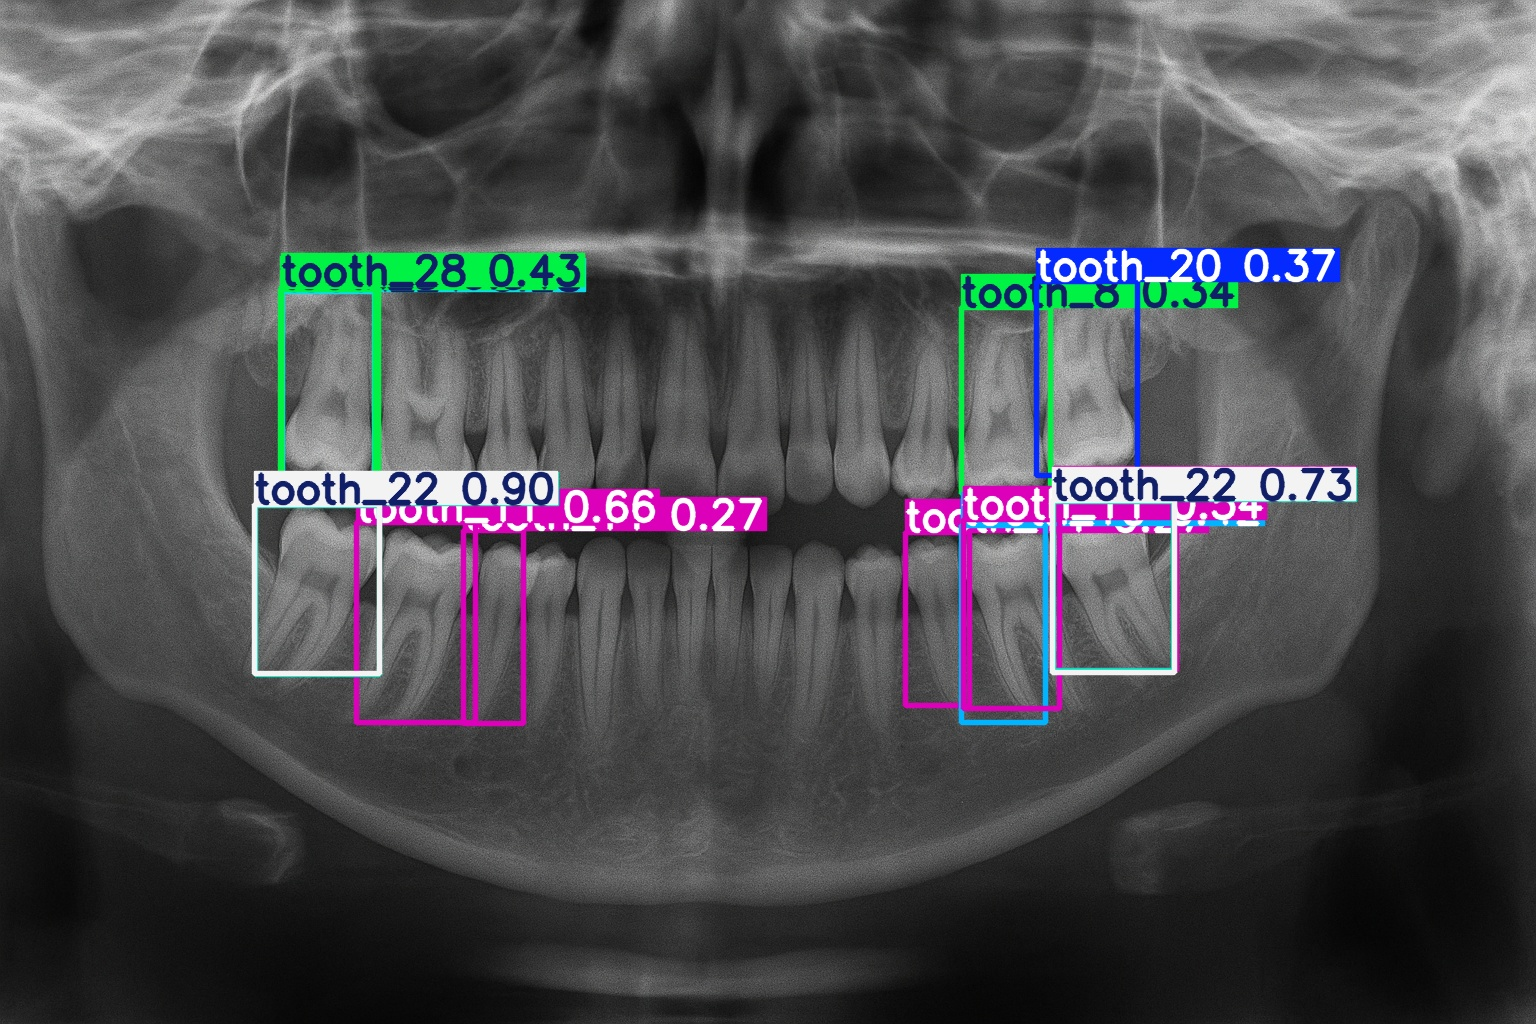

In [55]:
import os
from IPython.display import Image, display

# Check where YOLO saved predictions
output_dir = "runs/detect/predict"
print("Files in prediction folder:", os.listdir(output_dir))

# Show the first predicted image
pred_img = os.path.join(output_dir, os.listdir(output_dir)[0])
display(Image(filename=pred_img))


In [56]:
# Run inference on the entire test set
results = model.predict(
    source="/content/oralvis_project/dataset/test/images",
    save=True,
    conf=0.25
)



image 1/50 /content/oralvis_project/dataset/test/images/061339f1-20240911-110938655.jpg: 256x256 1 tooth_9, 1 tooth_10, 3 tooth_20s, 1 tooth_21, 1 tooth_22, 3 tooth_23s, 2 tooth_30s, 1 tooth_31, 210.7ms
image 2/50 /content/oralvis_project/dataset/test/images/1fc5e51d-20241219-142523942.jpg: 256x256 1 tooth_2, 1 tooth_5, 1 tooth_9, 1 tooth_16, 7 tooth_17s, 1 tooth_20, 1 tooth_30, 1 tooth_31, 196.4ms
image 3/50 /content/oralvis_project/dataset/test/images/23f1d012-20240628-115132889.jpg: 256x256 1 tooth_8, 1 tooth_9, 2 tooth_10s, 6 tooth_11s, 2 tooth_17s, 5 tooth_20s, 1 tooth_21, 3 tooth_22s, 6 tooth_23s, 2 tooth_28s, 1 tooth_31, 209.9ms
image 4/50 /content/oralvis_project/dataset/test/images/32bf2ab8-20250429-143954461.jpg: 256x256 2 tooth_9s, 1 tooth_10, 1 tooth_11, 3 tooth_20s, 2 tooth_22s, 5 tooth_23s, 1 tooth_28, 368.6ms
image 5/50 /content/oralvis_project/dataset/test/images/3eb9bb4a-20240713-104413422.jpg: 256x256 1 tooth_9, 1 tooth_10, 1 tooth_11, 5 tooth_20s, 1 tooth_21, 2 toot

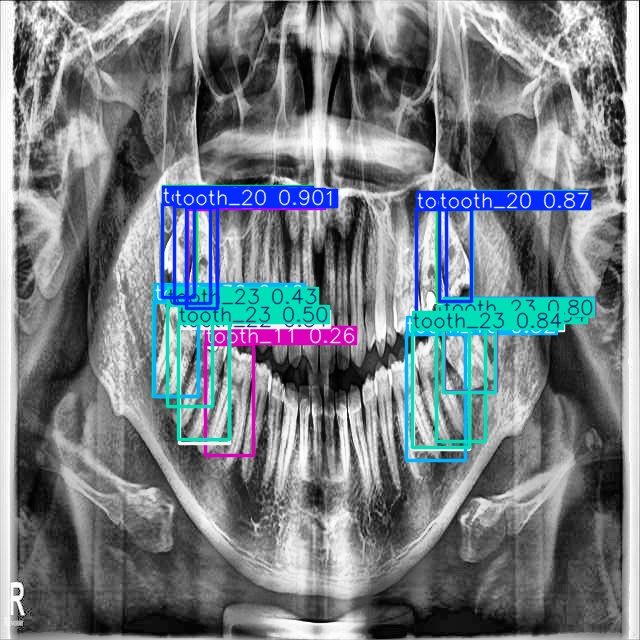

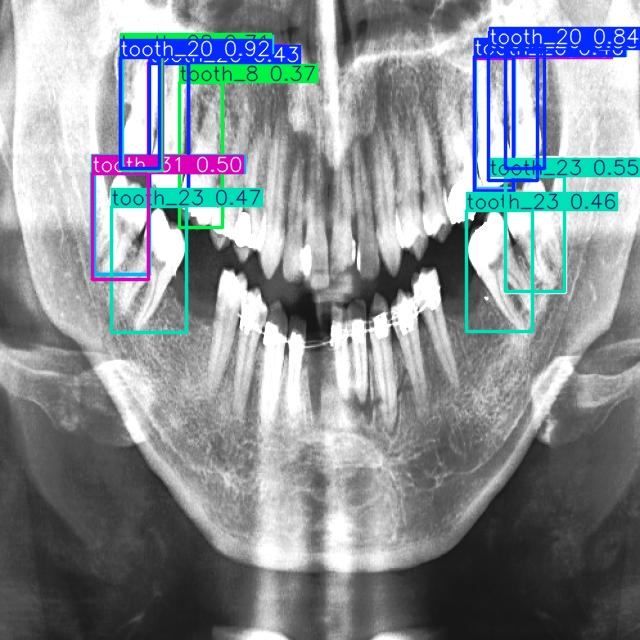

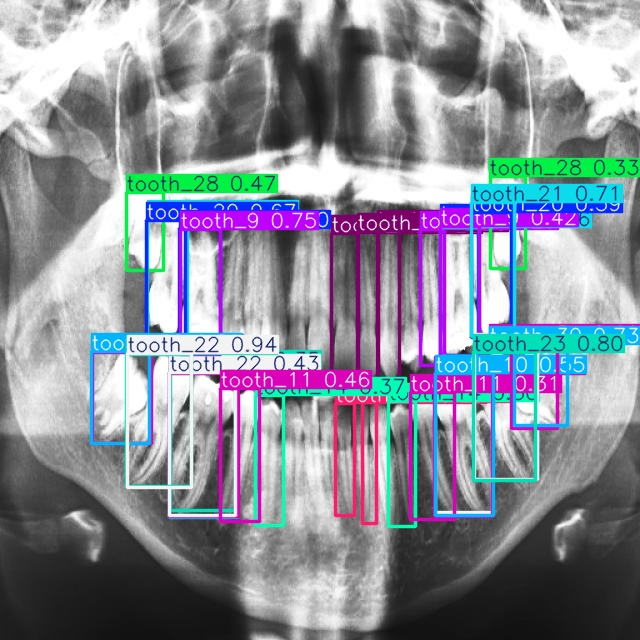

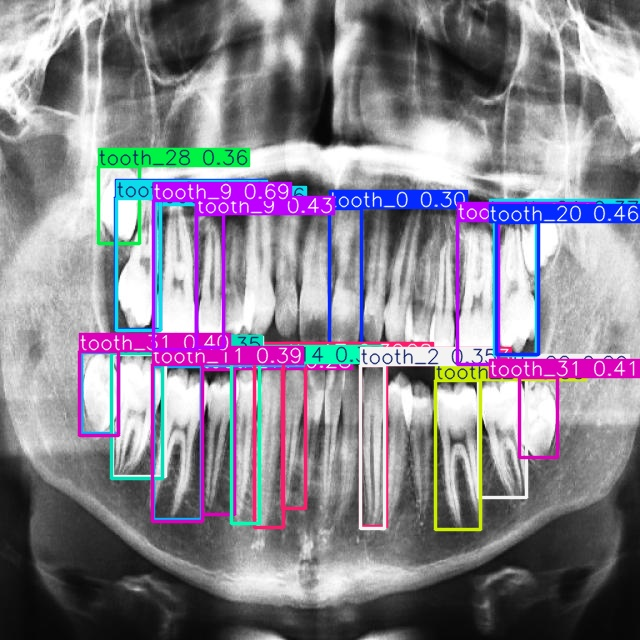

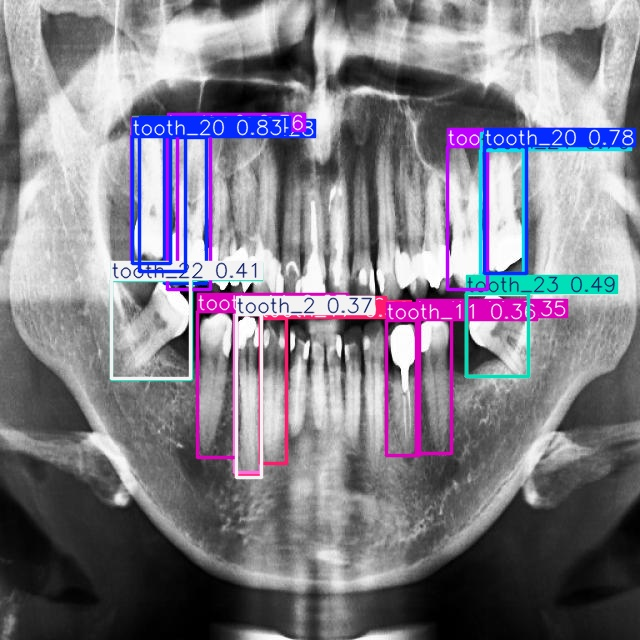

In [57]:
import os
from IPython.display import Image, display

output_dir = "runs/detect/predict"
for img_name in os.listdir(output_dir)[:5]:  # show first 5 results
    display(Image(filename=os.path.join(output_dir, img_name)))


In [58]:
metrics = model.val(data="/content/oralvis_project/data.yaml")
print(metrics)


Ultralytics 8.3.40 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/oralvis_project/dataset/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 34, len(boxes) = 2773. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.30s/it]


                   all        100       2773      0.228      0.488        0.2      0.119
               tooth_0         90         90     0.0737      0.233     0.0835     0.0423
               tooth_1         90         90      0.163      0.111      0.124     0.0684
               tooth_2         99        100      0.148       0.58      0.218      0.124
               tooth_3         98         99      0.101      0.152     0.0811     0.0335
               tooth_4         91         91      0.275      0.518      0.302      0.167
               tooth_5         96         96     0.0915      0.406     0.0813      0.038
               tooth_6         98         99       0.43     0.0101     0.0755     0.0233
               tooth_7         92         92      0.197      0.652       0.23      0.129
               tooth_8         81         81      0.132      0.531       0.13     0.0873
               tooth_9         80         80      0.198      0.925      0.279       0.17
              tooth_1

In [59]:
model.export(format="onnx")   # or "torchscript", "tflite", "engine"


Ultralytics 8.3.40 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/content/runs/detect/oralvis_yolov8s_test/weights/best.pt' with input shape (1, 3, 256, 256) BCHW and output shape(s) (1, 36, 1344) (21.4 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 144.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 181.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 165.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 12.7s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.0 opset 1

'/content/runs/detect/oralvis_yolov8s_test/weights/best.onnx'

In [60]:
!git clone https://github.com/ABINAVABI457/OralVis-Task-Submission.git
%cd OralVis-Task-Submission

Cloning into 'OralVis-Task-Submission'...
/content/OralVis-Task-Submission


In [61]:
!git add .
!git commit -m "Add project files for OralVis task"
!git push

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@d61698cfd9e8.(none)')
error: src refspec refs/heads/main does not match any
error: failed to push some refs to 'https://github.com/ABINAVABI457/OralVis-Task-Submission.git'


In [62]:
!git config --global user.email "abinavc457@gmail.com"
!git config --global user.name "ABINAV"

In [63]:
!git push

error: src refspec refs/heads/main does not match any
error: failed to push some refs to 'https://github.com/ABINAVABI457/OralVis-Task-Submission.git'


In [64]:
%cd OralVis-Task-Submission

[Errno 2] No such file or directory: 'OralVis-Task-Submission'
/content/OralVis-Task-Submission


In [65]:
!pwd

/content/OralVis-Task-Submission


In [66]:
!git add .
!git commit -m "Initial commit of project files"
!git push -u origin main

On branch main

Initial commit

nothing to commit (create/copy files and use "git add" to track)
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/ABINAVABI457/OralVis-Task-Submission.git'


In [67]:
!ls -F

In [68]:
!git add .
!git commit -m "Initial commit of project files"
!git push -u origin main

On branch main

Initial commit

nothing to commit (create/copy files and use "git add" to track)
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/ABINAVABI457/OralVis-Task-Submission.git'


In [69]:
!git add .
!git commit -m "Initial commit of project files"
!git push -u origin main

On branch main

Initial commit

nothing to commit (create/copy files and use "git add" to track)
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/ABINAVABI457/OralVis-Task-Submission.git'
